# Get the data

Get the data processed in the previous notebook (Exploratory Data Analysis)

In [1]:
import pandas as pd

In [2]:
from src.constants import X_TRAIN_PATH, X_TEST_PATH, Y_TRAIN_PATH, Y_TEST_PATH

# save the processed data to their corresponding files
X_train_as_pd = pd.read_csv(filepath_or_buffer=X_TRAIN_PATH, sep=',')
X_test_as_pd = pd.read_csv(filepath_or_buffer=X_TEST_PATH, sep=',')

y_train = pd.read_csv(filepath_or_buffer=Y_TRAIN_PATH, sep=',')
y_test = pd.read_csv(filepath_or_buffer=Y_TEST_PATH, sep=',')

In [3]:
# verify x_train
X_train_as_pd.head(1)

,0,1,2,3,4,5,6,7,8,9,...,3300,3301,3302,3303,3304,3305,3306,3307,3308,3309
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# verify x_test
X_test_as_pd.head(1)

,0,1,2,3,4,5,6,7,8,9,...,3300,3301,3302,3303,3304,3305,3306,3307,3308,3309
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# verify y_train
y_train.head(2)

,polarity
0,0
1,0


In [6]:
# verify y_test
y_test.head(2)

,polarity
0,0
1,1


## Transform the data to a numpy object

In [7]:
X_train = X_train_as_pd.to_numpy()
X_test = X_test_as_pd.to_numpy()

In [8]:
print(X_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Lets compare the three models

First we believed that the best model would be the Binomial naive bayes, because we believed the data was "binary", but that happened thanks to a misunderstood of how the vectorizer works. Knowing that the iput data is not binary, because the features are representing discrete counts or frequencies. So the best performing model should be the Multinomial.

## Step 1: Initialization and training of the models

In [9]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB

bernoulli_model = BernoulliNB()
bernoulli_model.fit(X_train, y_train['polarity'])

gaussian_model = GaussianNB()
gaussian_model.fit(X_train, y_train['polarity'])

multinomial_model = MultinomialNB()
multinomial_model.fit(X_train, y_train['polarity'])

models = [
    {
        'name': 'BernoulliNB',
        'model': bernoulli_model
    },
    {
        'name': 'GaussianNB',
        'model': gaussian_model
    },
    {
        'name': 'MultinomialNB',
        'model': multinomial_model
    },
]

## Step 2: Test the models

In [10]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             )

metrics = pd.DataFrame(columns=['name', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'model_confusion'])

# for each model calculate their metrics
for idx, model in enumerate(models):
    # make the prediction
    y_pred = model['model'].predict(X_test)
    
    # make the prediction of the probabilities of being one class or another
    y_prob = model['model'].predict_proba(X_test)
    
    # calculate the metrics
    model_accuracy = accuracy_score(y_test, y_pred)
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1 = f1_score(y_test, y_pred)
    model_auc_roc = roc_auc_score(y_test, y_prob[:, 1])
    model_confusion = confusion_matrix(y_test, y_pred)

    # add the metrics to the dataframe
    metrics.loc[idx] = [
        model['name'],
        model_accuracy,
        model_precision,
        model_recall,
        model_f1,
        model_auc_roc,
        model_confusion
    ]

In [11]:
metrics.head()

,name,accuracy,precision,recall,f1,roc_auc,model_confusion
0,BernoulliNB,0.770950,0.700000,0.396226,0.506024,0.843816,"[[117, 9], [32, 21]]"
1,GaussianNB,0.804469,0.687500,0.622642,0.653465,0.751797,"[[111, 15], [20, 33]]"
2,MultinomialNB,0.815642,0.727273,0.603774,0.659794,0.849955,"[[114, 12], [21, 32]]"


We can see that the Multinomial model is the best in the accuracy, precision and f1-score. The Gaussian model is the second best and the Bernoulli model has the worst metrics in almost all of them. Let's see the confusion matrix of each model.

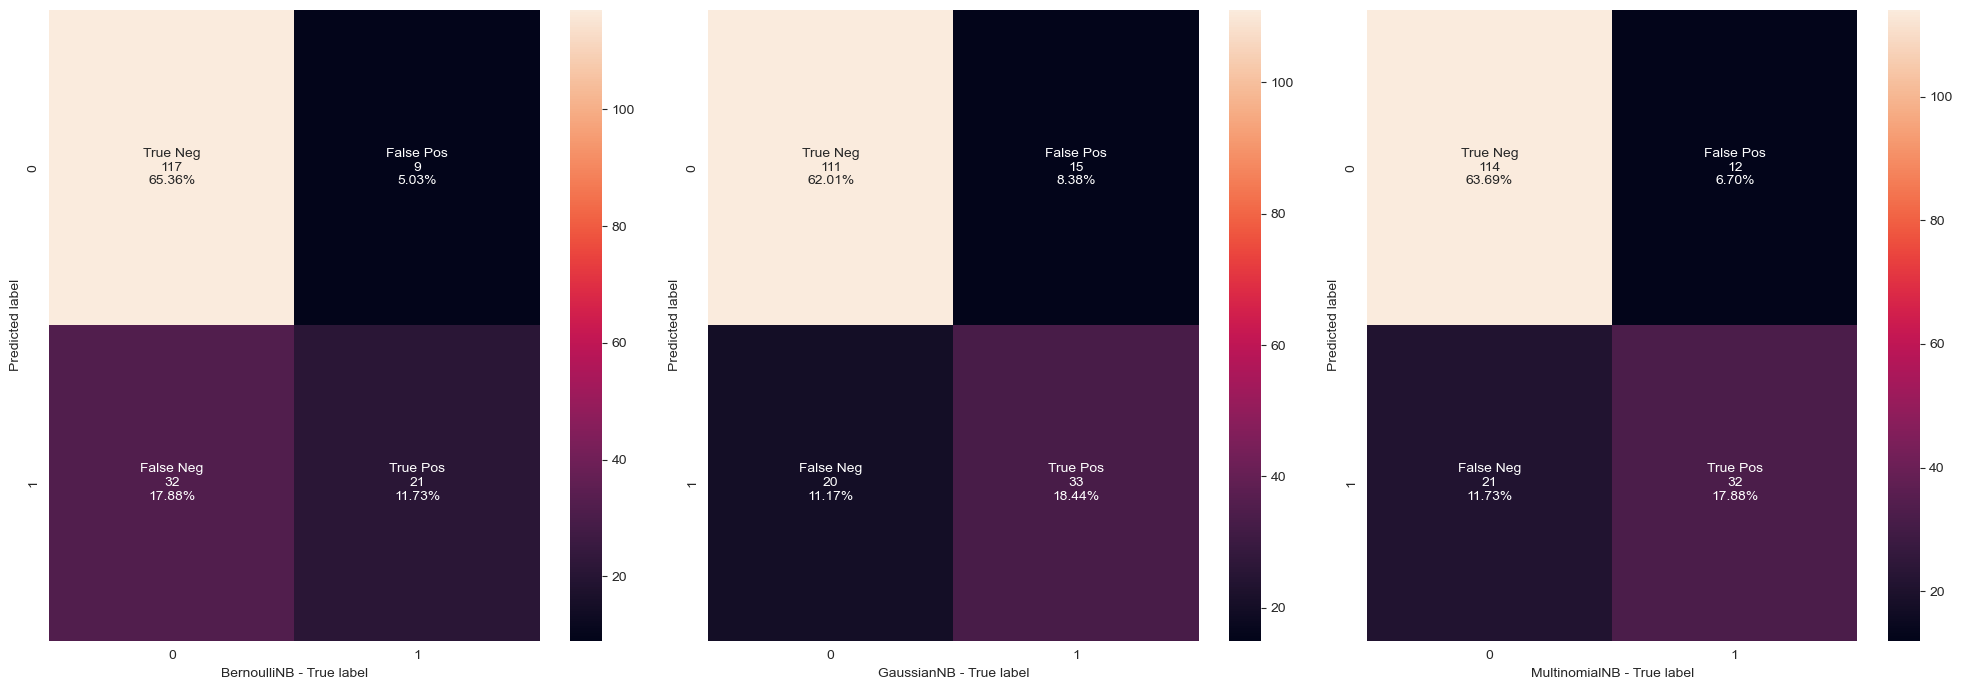

In [12]:
from src.draw_utils import get_groups_for_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

_, axis = plt.subplots(1, 3, figsize=(20, 7))
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

for row in metrics.itertuples():
    # get the confusion matrix
    confusion_matrix = row[7]

    # create the groups to display
    group_counts, group_percentages = get_groups_for_confusion_matrix(confusion=confusion_matrix)

    # labels to display
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # draw the confusion matrix
    sns.heatmap(
        ax=axis[row[0]],
        data=confusion_matrix,
        annot=labels,
        fmt=''
    ).set(
        xlabel=f'{row[1]} - True label', ylabel='Predicted label'
        )

plt.tight_layout()
plt.show()


We can see that indeed the Multinomial naive bayes is the best model, it has the best overall performance, is not the best in setting 0 or 1 label, but has the best overall classification.

# Option 2. Optimize the MultinomialNB

In [13]:
# create the new model
multinomial_opt_model = MultinomialNB()

## Step 1: Create the hyperparameter optimization model

In [14]:
from sklearn.model_selection import GridSearchCV

# define the parameters that we want to adjust by hand, depends on the model to use
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'fit_prior': [True, False]
}

# initialize the grid
grid = GridSearchCV(multinomial_opt_model, param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

## Step 2: Fit the model

In [15]:
grid.fit(X_train, y_train['polarity'])

print(f"Best hyperparameters: {grid.best_params_}")

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best hyperparameters: {'alpha': 2.0, 'fit_prior': False}


## Step 3: Get the best model and predict

In [16]:
# get the best parameters and model
best_model: MultinomialNB = grid.best_estimator_

In [17]:
# predict the values
y_pred = best_model.predict(X_test)

In [18]:
# make the prediction of the probabilities of being one class or another
y_prob = best_model.predict_proba(X_test)

## Step 4: Metrics of the model

In [19]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             log_loss, classification_report)

optimized_model_accuracy = accuracy_score(y_test, y_pred)
optimized_model_precision = precision_score(y_test, y_pred)
optimized_model_recall = recall_score(y_test, y_pred)
optimized_model_f1 = f1_score(y_test, y_pred)
optimized_model_auc_roc = roc_auc_score(y_test, y_prob[:, 1])
optimized_model_confusion = confusion_matrix(y_test, y_pred)
optimized_model_report = classification_report(y_test, y_pred)

print(f'Accuracy: {optimized_model_accuracy}')
print(f'Precision: {optimized_model_precision}')
print(f'Recall: {optimized_model_recall}')
print(f'F1-Score: {optimized_model_f1}')
print(f'AUC-ROC: {optimized_model_auc_roc}')
print(f'Classification Report:\n{optimized_model_report}')

Accuracy: 0.8212290502793296
Precision: 0.723404255319149
Recall: 0.6415094339622641
F1-Score: 0.68
AUC-ROC: 0.8442647499251273
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       126
           1       0.72      0.64      0.68        53

    accuracy                           0.82       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.82      0.82      0.82       179



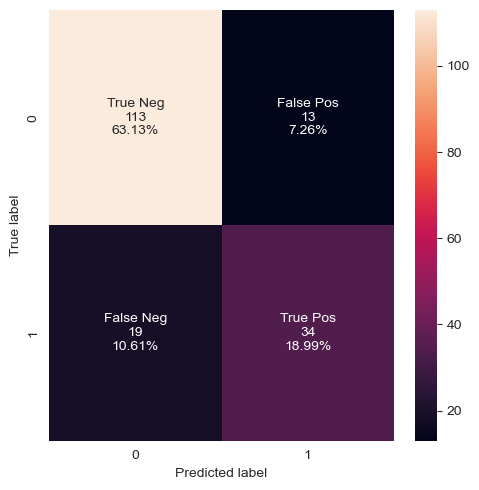

In [20]:
from src.draw_utils import draw_confusion_matrix

draw_confusion_matrix(confusion=optimized_model_confusion)

The interpretation of a confusion matrix is as follows:

- **True positive (TP)**: corresponds to the number 113 and are the cases where the model predicted positive **(the person has diabetes)** and the actual class is also positive.
- **True negative (TN)**: Corresponds to the number 34 and are the cases where the model predicted negative **(the person does not have diabetes)** and the actual class is also negative.
- **False positive (FP)**: Corresponds to the number 13 and are the cases in which the model predicted positive, but the actual class is negative.
- **False negative (FN)**: Corresponds to the number 19 and are the cases where the model predicted negative, but the actual class is positive.

# Conclusion

In [21]:

from src.markdown_utils import show_comparison_table

# set the metrics to use
metric_list: list[str] = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

# get the metrics of the default and optimized list values
default_model_metrics: list[float] = [metrics.loc[2, 'accuracy'], metrics.loc[2, 'precision'], metrics.loc[2, 'recall'],
                                      metrics.loc[2, 'f1'], metrics.loc[2, 'roc_auc']]
optimized_model_metrics: list[float] = [optimized_model_accuracy, optimized_model_precision, optimized_model_recall,
                                        optimized_model_f1, optimized_model_auc_roc]

# construct the Markdown table
show_comparison_table(
    metric_names=metric_list,
    default_metrics=default_model_metrics,
    optimized_metrics=optimized_model_metrics,
)

| Metric | Default Model | Optimized Model |
|---|---|---|
| Accuracy | 0.816 | 0.821 |
| Precision | 0.727 | 0.723 |
| Recall | 0.604 | 0.642 |
| F1-Score | 0.66 | 0.68 |
| AUC-ROC | 0.85 | 0.844 |


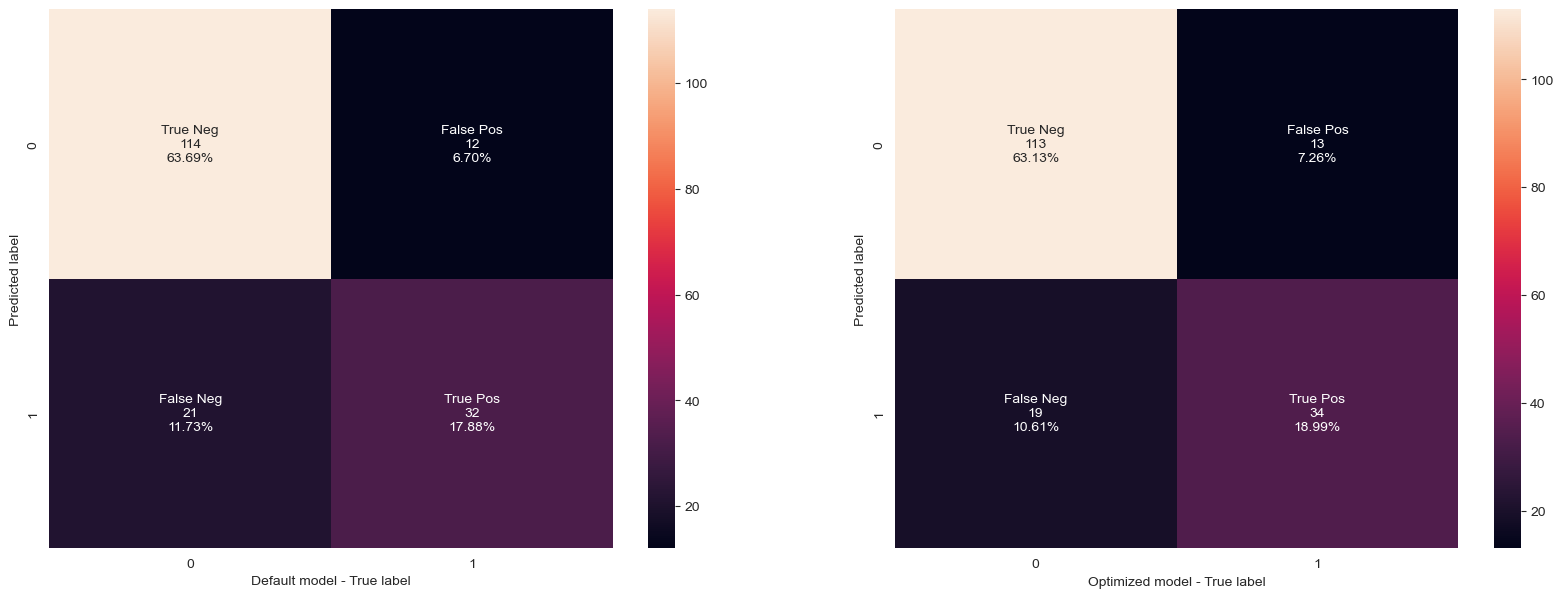

<Figure size 1000x500 with 0 Axes>

In [23]:
from src.draw_utils import draw_comparison_confusion_matrices

draw_comparison_confusion_matrices(
    confusion_1=metrics.loc[2, 'model_confusion'], confusion_2=optimized_model_confusion, confusion_matrix_1_name='Default model',
    confusion_matrix_2_name='Optimized model'
    )

We can see that the optimized model is better in almost all the metrics, but the default model has better precision and auc_roc. The optimized model is better in the accuracy, recall and f1-scorem which makes it better with the label that has the least amount of values from data.

# Save the final model

Save the final model for future use

In [25]:
from pickle import dump

dump(model, open("../models/naive_bayes_opt_multinomial.sav", "wb"))